In [1]:
import numpy as np
from sklearn.datasets import fetch_20newsgroups
categories = [ 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware',
                'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey']
train_data = fetch_20newsgroups(subset='train', categories=categories, shuffle=True, random_state=42)
test_data = fetch_20newsgroups(subset='test', categories=categories, shuffle=True, random_state=42)
all_data = fetch_20newsgroups(subset='train', shuffle=True, random_state=42)

### (a) 
### Number of Documents in Computer Technology and Recreational Activity

In [2]:
doc_cnt = []
doc_group = []
for i in range(len(train_data.target_names)):
    doc_cnt.append(np.count_nonzero(train_data.target==i))
    doc_group.append(train_data.target_names[i])
 
print("The total number of documents in Computer Technology: %d" % sum(doc_cnt[0:4]))
print("The total number of documents in Recreational Activity: %d" % sum(doc_cnt[4:8]))

The total number of documents in Computer Technology: 2343
The total number of documents in Recreational Activity: 2389


### Plot the histogram

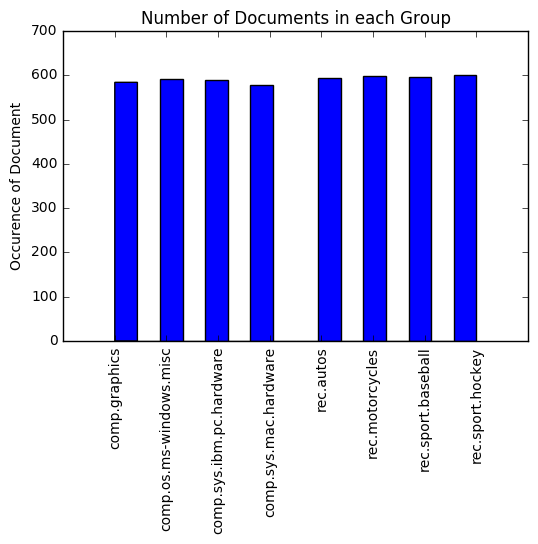

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.hist(train_data.target, bins=16, align='mid')
plt.xticks(range(8), doc_group, rotation='vertical')
plt.title("Number of Documents in each Group")
plt.ylabel("Occurence of Document")
plt.xlim([-1,8])
plt.ylim([0,700])

plt.show()

In [4]:
from sklearn.feature_extraction.text import CountVectorizer
import nltk
import string
from nltk.stem import PorterStemmer

stemmer = PorterStemmer()
def tokenize_and_stem(text):
    tokens = nltk.tokenize.word_tokenize(text)
    tokens = [token.strip(string.punctuation)
                for token in tokens if token.isalnum()]
    tokens = [stemmer.stem(token) for token in tokens]
    return tokens

vectorizer = CountVectorizer(min_df=1, stop_words='english', tokenizer=tokenize_and_stem)
# vectorizer = CountVectorizer(min_df=1, stop_words='english')
vectorizer

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words='english',
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=<function tokenize_and_stem at 0x1105b81e0>,
        vocabulary=None)

In [5]:
# concat all documents with respect to class
XX = [x for x in range(len(all_data.target_names))]
for i in range(len(all_data.data)):
    XX[all_data.target[i]] = str(XX[all_data.target[i]])+" "+all_data.data[i]
X1 = vectorizer.fit_transform(XX)
X1.shape

(20, 74556)

In [6]:
from sklearn.feature_extraction.text import TfidfTransformer
# use TFIDF functino to do TFICF
tfidf_transformer = TfidfTransformer()
tfidf_transformer = TfidfTransformer(sublinear_tf=True, use_idf=True)
X_train_tficf = tfidf_transformer.fit_transform(X1)

In [7]:
# list the top 10 terms in the following 4 groups
classes = []
categories = ['comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'misc.forsale', 'soc.religion.christian']
for i in range(len(categories)):
    classes.append(all_data.target_names.index(categories[i]))

for i in range(len(categories)):
    arr = np.array(X_train_tficf.toarray()[classes[i],:])
    max_term = arr.argsort()[-10:][::-1]
    print("Top 10 terms in %s" % categories[i])
    for j in max_term:
        print(list(vectorizer.vocabulary_.keys())[j])

Top 10 terms in comp.sys.ibm.pc.hardware
lighli
jsbh
7v4cn7be
xp3z
unplug
75038
lajoi
stultif
useag
unruley
Top 10 terms in comp.sys.mac.hardware
727
gpatapi
albion
odasi
mst
p2z
tpremo
x11r5pl19
srubio
a01
Top 10 terms in misc.forsale
fraca
hoetker
burasi
ma170saj
wno1p
montant
ksand
farsid
vwwt
undergrad
Top 10 terms in soc.religion.christian
obstin
bethd
briberi
horst
ongh
harmful
11797
yazilarin
hogg
ds1262


In [8]:
# vectorize training data and test data
X = vectorizer.fit_transform(train_data.data)
X_test = vectorizer.fit_transform(test_data.data)

# TFIDF
X_train_tfidf = tfidf_transformer.fit_transform(X)
X_test_tfidf = tfidf_transformer.fit_transform(X_test)
X_train_tfidf.shape

(4732, 43614)

In [9]:
print(X.shape)
print(X_train_tfidf.shape)
# print list(vectorizer.vocabulary_.keys())[0:10]
print(len(list(vectorizer.vocabulary_.keys()))) # number of terms

(4732, 43614)
(4732, 43614)
30490


In [10]:
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

svd = TruncatedSVD(n_components=50, n_iter=7, random_state=42)
lsa = make_pipeline(svd, Normalizer(copy=False))
X_train_lsa = lsa.fit_transform(X_train_tfidf)
X_train_lsa.shape

(4732, 50)

In [15]:
# scale to range [0,1]
from sklearn.preprocessing import MinMaxScaler
min_max_scaler = MinMaxScaler()
X_train_lsa_minmax = min_max_scaler.fit_transform(X_train_lsa)
X_train_lsa_minmax.shape

(4732, 50)

### Reassign labels for train_data and test_data

In [16]:
train_labels = [0 if x<4 else 1 for x in train_data.target]
train_labels = np.asarray(train_labels)

test_labels = [0 if x<4 else 1 for x in test_data.target]
test_labels = np.asarray(test_labels)

### Pipeline - Naive Bayes

In [18]:
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB

nb_text_clf = Pipeline([('vect', vectorizer),
                     ('tfidf', tfidf_transformer),
                     ('svd', lsa),
                     ('scaler', MinMaxScaler()),
                     ('clf', MultinomialNB()),
])

In [19]:
nb_text_clf = nb_text_clf.fit(train_data.data, train_labels)

In [20]:
predicted = nb_text_clf.predict(test_data.data)
np.mean(predicted == test_labels) 

0.9555555555555556

In [21]:
nb_predicted_prob = nb_text_clf.predict_proba(test_data.data)

In [22]:
print(nb_predicted_prob)
print(nb_predicted_prob[:,1])

[[ 0.52472364  0.47527636]
 [ 0.52812603  0.47187397]
 [ 0.49459684  0.50540316]
 ..., 
 [ 0.46541323  0.53458677]
 [ 0.52870421  0.47129579]
 [ 0.55323678  0.44676322]]
[ 0.47527636  0.47187397  0.50540316 ...,  0.53458677  0.47129579
  0.44676322]


In [23]:
from sklearn import metrics
print(metrics.classification_report(test_labels, predicted,
    target_names=['Computer Technology', 'Recreational activity']))

metrics.confusion_matrix(test_labels, predicted)

                       precision    recall  f1-score   support

  Computer Technology       0.98      0.93      0.95      1560
Recreational activity       0.93      0.99      0.96      1590

          avg / total       0.96      0.96      0.96      3150



array([[1443,  117],
       [  23, 1567]])

In [24]:
# plot ROC curve
from sklearn.metrics import roc_curve, auc

nb_fpr, nb_tpr, thresholds = roc_curve(test_labels, nb_predicted_prob[:,1])
nb_roc_auc = auc(nb_fpr, nb_tpr)

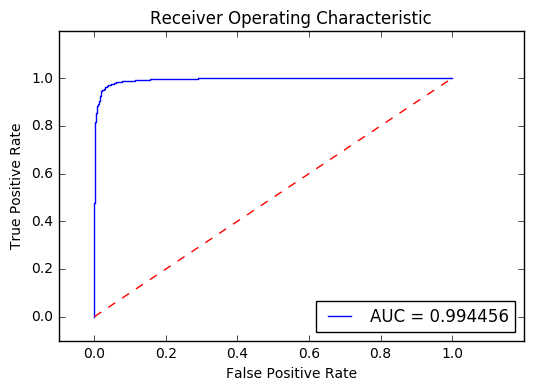

In [25]:
plt.title('Receiver Operating Characteristic')
plt.plot(nb_fpr, nb_tpr, 'b',
label='AUC = %f'% nb_roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### Linear SVM


In [26]:
from sklearn.svm import SVC
lsvm_text_clf = Pipeline([('vect', vectorizer),
                     ('tfidf', tfidf_transformer),
                     ('svd', lsa),
                     ('clf', SVC(kernel='linear')),
])

In [27]:
SVC()

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [28]:
# train
lsvm_text_clf = lsvm_text_clf.fit(train_data.data, train_labels)

In [29]:
# test
lsvm_decision_function = lsvm_text_clf.decision_function(test_data.data)
lsvm_predicted_0 = lsvm_text_clf.predict(test_data.data)

In [30]:
# threshold = 0
print("Accuracy = " + str(np.mean(lsvm_predicted_0 == test_labels)))
print(metrics.classification_report(test_labels, lsvm_predicted_0,
    target_names=['Computer Technology', 'Recreational activity']))

metrics.confusion_matrix(test_labels, lsvm_predicted_0)

Accuracy = 0.976507936508
                       precision    recall  f1-score   support

  Computer Technology       0.98      0.97      0.98      1560
Recreational activity       0.97      0.98      0.98      1590

          avg / total       0.98      0.98      0.98      3150



array([[1512,   48],
       [  26, 1564]])

In [31]:
lsvm_decision_function

array([-3.09839642, -2.38073887,  0.32054737, ...,  1.2709843 ,
       -2.57535378, -4.13932275])

In [32]:
# plot ROC curve

lsvm_fpr, lsvm_tpr, thresholds = roc_curve(test_labels, lsvm_decision_function)
lsvm_roc_auc = auc(lsvm_fpr, lsvm_tpr)

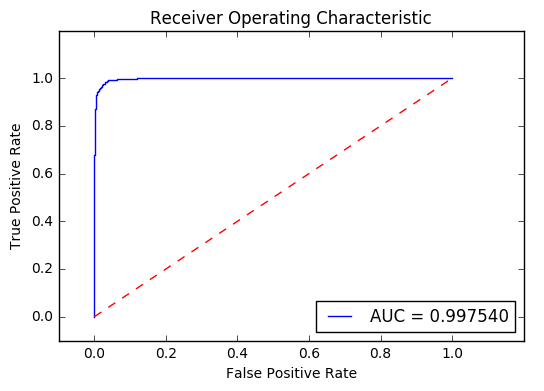

In [33]:
plt.title('Receiver Operating Characteristic')
plt.plot(lsvm_fpr, lsvm_tpr, 'b',
label='AUC = %f'% lsvm_roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### Soft Margin SVM

In [34]:
# 5-fold cross validation
from sklearn.model_selection import KFold
import math

max_acc = 0
kf = KFold(n_splits=5)
for k in range(-3,4):
    print("Regularization Coefficient = %d" %k)
    for train, test in kf.split(train_data.data):
        X_train = np.array(train_data.data)[train]
        y_train = train_labels[train]
        X_test = np.array(train_data.data)[test]
        y_test = train_labels[test]


        lsvm_tmp_clf = Pipeline([('vect', vectorizer),
                             ('tfidf', tfidf_transformer),
                             ('svd', lsa),
                             ('clf', SVC(C=math.pow(10,k), kernel='linear')),
        ])
        lsvm_tmp_clf = lsvm_tmp_clf.fit(X_train, y_train)
        predicted = lsvm_tmp_clf.predict(X_test)
        accuracy = np.mean(predicted == y_test)
        print(accuracy)
        if accuracy>max_acc:
            max_acc = accuracy
            lsvm_sm_clf = lsvm_tmp_clf

print(lsvm_sm_clf)

Regularization Coefficient = -3
0.458289334741
0.465681098205
0.510570824524
0.508456659619
0.512684989429
Regularization Coefficient = -2
0.968321013728
0.972544878564
0.966173361522
0.977801268499
0.968287526427
Regularization Coefficient = -1
0.974656810982
0.979936642027
0.971458773784
0.980972515856
0.976744186047
Regularization Coefficient = 0
0.974656810982
0.980992608237
0.977801268499
0.979915433404
0.973572938689
Regularization Coefficient = 1
0.975712777191
0.978880675818
0.977801268499
0.977801268499
0.977801268499
Regularization Coefficient = 2
0.9767687434
0.979936642027
0.976744186047
0.976744186047
0.977801268499
Regularization Coefficient = 3
0.975712777191
0.979936642027
0.976744186047
0.976744186047
0.978858350951
Pipeline(steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1

In [35]:
# test
lsvm_decision_function = lsvm_sm_clf.decision_function(test_data.data)
lsvm_predicted_0 = lsvm_sm_clf.predict(test_data.data)

In [36]:
# threshold = 0
print("Accuracy = " + str(np.mean(lsvm_predicted_0 == test_labels)))
print(metrics.classification_report(test_labels, lsvm_predicted_0,
    target_names=['Computer Technology', 'Recreational activity']))

metrics.confusion_matrix(test_labels, lsvm_predicted_0)

Accuracy = 0.949841269841
                       precision    recall  f1-score   support

  Computer Technology       0.95      0.95      0.95      1560
Recreational activity       0.95      0.95      0.95      1590

          avg / total       0.95      0.95      0.95      3150



array([[1477,   83],
       [  75, 1515]])

In [37]:
lsvm_decision_function

array([-2.96587506, -3.05685044, -0.10158871, ...,  1.7952753 ,
       -2.62809094, -4.7324169 ])

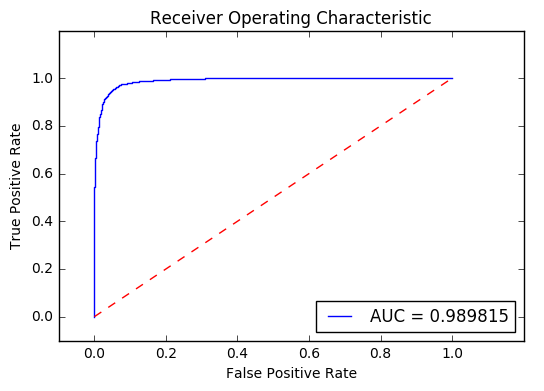

In [38]:
# plot ROC curve

lsvm_fpr, lsvm_tpr, thresholds = roc_curve(test_labels, lsvm_decision_function)
lsvm_roc_auc = auc(lsvm_fpr, lsvm_tpr)
plt.title('Receiver Operating Characteristic')
plt.plot(lsvm_fpr, lsvm_tpr, 'b',
label='AUC = %f'% lsvm_roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### Logistic Regression

In [194]:
from sklearn.linear_model import LogisticRegression
lgr_text_clf = Pipeline([('vect', vectorizer),
                     ('tfidf', tfidf_transformer),
                     ('svd', lsa),
                     ('clf', LogisticRegression()),
])

In [195]:
lgr_text_clf = lgr_text_clf.fit(train_data.data, train_labels)

In [196]:
# test
lgr_predicted_prob = lgr_text_clf.predict_proba(test_data.data)[:,1]
lgr_predicted = lgr_text_clf.predict(test_data.data)
print(lgr_predicted_prob)
print(lgr_predicted)

[ 0.01303386  0.02413573  0.58714798 ...,  0.8956578   0.02334491
  0.00183684]
[0 0 1 ..., 1 0 0]


In [197]:
# evaluation
print()"Accuracy = " + str(np.mean(lgr_predicted == test_labels))) 
print(metrics.classification_report(test_labels, lgr_predicted,
    target_names=['Computer Technology', 'Recreational activity']))

metrics.confusion_matrix(test_labels, lgr_predicted)

Accuracy = 0.977142857143
                       precision    recall  f1-score   support

  Computer Technology       0.99      0.97      0.98      1560
Recreational activity       0.97      0.99      0.98      1590

          avg / total       0.98      0.98      0.98      3150



array([[1511,   49],
       [  23, 1567]])

In [198]:
# plot ROC
lgr_fpr, lgr_tpr, thresholds = roc_curve(test_labels, lgr_predicted_prob)
lgr_roc_auc = auc(lgr_fpr, lgr_tpr)

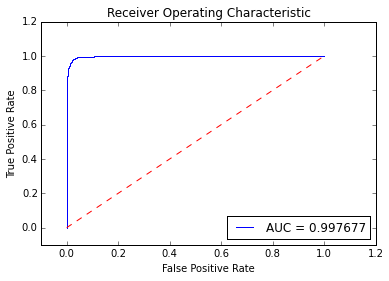

In [199]:
plt.title('Receiver Operating Characteristic')
plt.plot(lgr_fpr, lgr_tpr, 'b',
label='AUC = %f'% lgr_roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### Logistic Regression - regularization

In [230]:
from sklearn.linear_model import LogisticRegression
lgr_pp = Pipeline([('vect', vectorizer),
                     ('tfidf', tfidf_transformer),
                     ('svd', lsa),
#                      ('lclf', LogisticRegression(penalty='l1')),
])
lgr_l1_text_vec = lgr_pp.fit_transform(train_data.data)
lgr_l1_text_clf = LogisticRegression(penalty='l1')
# lgr_l1_text_clf = lgr.fit(lgr_l1_text_vec)
lgr_l1_text_vec

array([[ 0.54406532,  0.4233597 ,  0.02223151, ...,  0.03488536,
         0.06285193, -0.12324147],
       [ 0.32390161,  0.30530981, -0.18419521, ..., -0.24405923,
         0.06738693,  0.1747485 ],
       [ 0.60786577,  0.00155686,  0.42958412, ..., -0.0128331 ,
        -0.07950178, -0.20826065],
       ..., 
       [ 0.47081045,  0.38414682, -0.12977756, ..., -0.07030989,
        -0.045724  , -0.05571105],
       [ 0.64486216,  0.43733454,  0.00349631, ..., -0.00419814,
         0.12247726,  0.09381239],
       [ 0.42400656, -0.17615309, -0.04520188, ..., -0.01280832,
         0.13948862, -0.00093582]])

In [231]:
# lgr_l1_text_vec
lgr_l1_text_clf = lgr_l1_text_clf.fit(lgr_l1_text_vec, train_labels)

In [233]:
# test
# lgr_l1_predicted_prob = lgr_l1_text_clf.predict_proba(test_data.data)[:,1]
lgr_l1_test_vec = lgr_pp.fit_transform(test_data.data)
lgr_l1_predicted = lgr_l1_text_clf.predict(lgr_l1_test_vec)


In [234]:
# evaluation
print "Accuracy = " + str(np.mean(lgr_l1_predicted == test_labels)) 
print(metrics.classification_report(test_labels, lgr_l1_predicted,
    target_names=['Computer Technology', 'Recreational activity']))

metrics.confusion_matrix(test_labels, lgr_l1_predicted)

Accuracy = 0.944444444444
                       precision    recall  f1-score   support

  Computer Technology       0.94      0.95      0.94      1560
Recreational activity       0.95      0.94      0.94      1590

          avg / total       0.94      0.94      0.94      3150



array([[1477,   83],
       [  92, 1498]])

In [235]:
lgr_l1_text_clf.coef_

array([[ -9.39625622e-01,   2.62469573e+01,   1.33012635e+01,
         -5.91342854e+00,  -5.05319406e+00,   0.00000000e+00,
          2.56533125e+00,   0.00000000e+00,   8.12491521e+00,
          5.34146165e+00,   1.84802421e+00,   1.75047911e-01,
          1.01358703e+00,  -3.02379681e+00,  -9.96526484e-01,
          0.00000000e+00,  -1.00623389e+00,   0.00000000e+00,
          3.12592140e+00,   0.00000000e+00,   0.00000000e+00,
         -2.65748857e+00,   0.00000000e+00,   1.54932089e+00,
         -2.37251962e+00,   0.00000000e+00,  -9.45092913e-01,
         -8.67870239e-01,  -2.79819665e+00,   0.00000000e+00,
         -1.55881919e-01,   4.65706181e-01,   9.79787675e-03,
          2.18595965e+00,  -8.85258337e-01,   2.81515759e+00,
          0.00000000e+00,   0.00000000e+00,   1.42839783e+00,
          0.00000000e+00,   8.07320552e-01,   0.00000000e+00,
          1.16038779e-02,   2.80333676e+00,   0.00000000e+00,
          1.73161961e-01,   0.00000000e+00,   0.00000000e+00,
        

### Multiclass Classfication

In [236]:
# get data
categories = [ 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'misc.forsale', 'soc.religion.christian']
mul_train_data = fetch_20newsgroups(subset='train', categories=categories, shuffle=True, random_state=42)
mul_test_data = fetch_20newsgroups(subset='test', categories=categories, shuffle=True, random_state=42)

### Naive Bayes

In [242]:
mul_nb_text_clf = nb_text_clf.fit(mul_train_data.data, mul_train_data.target)

In [243]:
mul_nb_predicted = mul_nb_text_clf.predict(mul_test_data.data)
np.mean(mul_nb_predicted == mul_test_data.target) 

0.86453674121405755

In [244]:
print(metrics.classification_report(mul_test_data.target, mul_nb_predicted,
    target_names=mul_test_data.target_names))

metrics.confusion_matrix(mul_test_data.target, mul_nb_predicted)

                          precision    recall  f1-score   support

comp.sys.ibm.pc.hardware       0.73      0.92      0.81       392
   comp.sys.mac.hardware       0.89      0.71      0.79       385
            misc.forsale       0.93      0.86      0.89       390
  soc.religion.christian       0.95      0.97      0.96       398

             avg / total       0.87      0.86      0.86      1565



array([[359,  17,   9,   7],
       [ 88, 273,  17,   7],
       [ 36,  11, 335,   8],
       [  6,   5,   1, 386]])

### Multiclass SVM - one vs one

In [245]:
mul_lsvm_text_clf = Pipeline([('vect', vectorizer),
                     ('tfidf', tfidf_transformer),
                     ('svd', lsa),
                     ('clf', SVC(decision_function_shape='ovo')),
])

In [246]:
mul_lsvm_text_clf = mul_lsvm_text_clf.fit(mul_train_data.data, mul_train_data.target)

In [247]:
mul_lsvm_predicted = mul_lsvm_text_clf.predict(mul_test_data.data)
mul_lsvm_dec = mul_lsvm_text_clf.decision_function(mul_test_data.data)
mul_lsvm_dec.shape

(1565, 6)

In [249]:
np.mean(mul_lsvm_predicted == mul_test_data.target) 

0.88881789137380196

In [250]:
print(metrics.classification_report(mul_test_data.target, mul_lsvm_predicted,
    target_names=mul_test_data.target_names))

metrics.confusion_matrix(mul_test_data.target, mul_lsvm_predicted)

                          precision    recall  f1-score   support

comp.sys.ibm.pc.hardware       0.77      0.91      0.83       392
   comp.sys.mac.hardware       0.89      0.79      0.84       385
            misc.forsale       0.93      0.88      0.91       390
  soc.religion.christian       0.99      0.97      0.98       398

             avg / total       0.90      0.89      0.89      1565



array([[356,  27,   9,   0],
       [ 67, 305,  12,   1],
       [ 35,  11, 343,   1],
       [  7,   0,   4, 387]])

### Multiclass SVM - one vs rest

In [252]:
from sklearn.svm import LinearSVC
mul_lsvm2_text_clf = Pipeline([('vect', vectorizer),
                     ('tfidf', tfidf_transformer),
                     ('svd', lsa),
                     ('clf', LinearSVC()),
])

In [253]:
mul_lsvm2_text_clf = mul_lsvm2_text_clf.fit(mul_train_data.data, mul_train_data.target)

In [254]:
mul_lsvm2_predicted = mul_lsvm2_text_clf.predict(mul_test_data.data)
mul_lsvm2_dec = mul_lsvm2_text_clf.decision_function(mul_test_data.data)
mul_lsvm_dec.shape

(1565, 6)

In [255]:
np.mean(mul_lsvm2_predicted == mul_test_data.target) 

0.89904153354632588

In [256]:
print(metrics.classification_report(mul_test_data.target, mul_lsvm2_predicted,
    target_names=mul_test_data.target_names))

metrics.confusion_matrix(mul_test_data.target, mul_lsvm2_predicted)

                          precision    recall  f1-score   support

comp.sys.ibm.pc.hardware       0.85      0.88      0.86       392
   comp.sys.mac.hardware       0.88      0.83      0.85       385
            misc.forsale       0.87      0.91      0.89       390
  soc.religion.christian       0.99      0.98      0.99       398

             avg / total       0.90      0.90      0.90      1565



array([[343,  29,  19,   1],
       [ 39, 318,  27,   1],
       [ 21,  13, 355,   1],
       [  1,   0,   6, 391]])